# [SF-DST] Recommendation Challenge

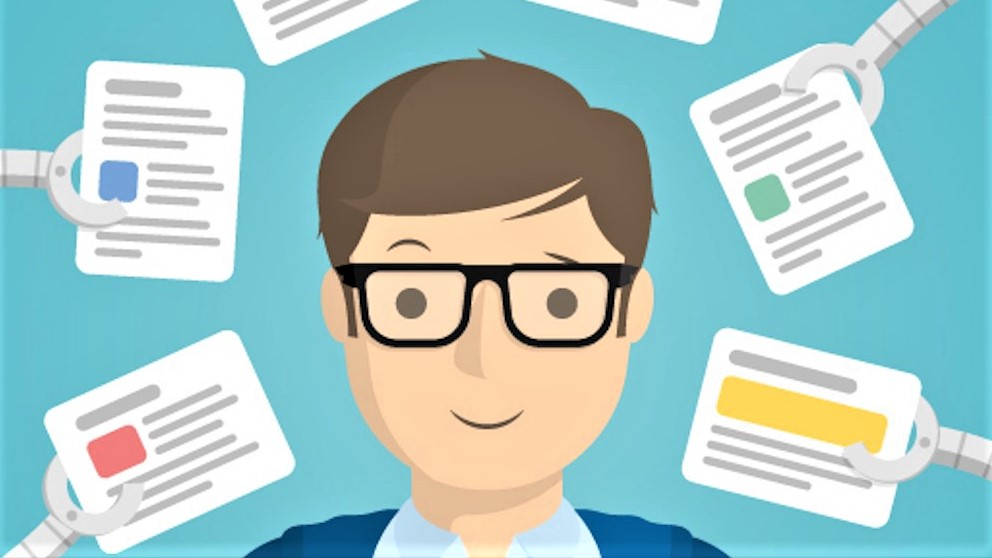

Purpose of this competition is to create recommender system based on user reviews

- overall - customer's rating
- verified - was the review verified or not
- reviewTime - review time
- reviewerName - reviewer's name
- reviewText - reviews text
- summary - summary of review
- vote - reviews upvotes
- style - metadata
- image - product image
- userid - user ID
- itemid - item ID
- id - prediction ID

# Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# Any results you write to the current directory are saved as output.
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import scipy.sparse as sparse

from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score,plot_roc_curve
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

import scipy.sparse as sparse

import matplotlib.pyplot as plt
import re
import gc
import ujson
import json
from pydantic import BaseModel, ValidationError, validator
from typing import List,Optional
from datetime import datetime

C:\Users\serge\anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [3]:
RANDOM_SEED = 42
folder = 'C:/Users/serge/Downloads/recommendationsv4/'

# Functions

In [4]:
class Grocery(BaseModel):
    '''
    Class to serialize Grocery
    '''
    category: Optional[List]
    description: Optional[List]
    price: Optional[str]
    title: Optional[str]
    also_view: Optional[List]
    date: Optional[str]
    rank: Optional[str]
    also_buy: Optional[List]
    main_cat: Optional[str]
    image: Optional[List]
    asin: str

    @validator('rank',pre=True, always=True)
    def check_type(cls, value):
        if type(value) == list:
            temp = re.findall(r'\d+(?:,\d+)?', value[0])
            number = temp[0].replace(',','.')

            return float(number)
        elif type(value) == str:
            temp = re.findall(r'\d+(?:,\d+)?', value)
            number = temp[0].replace(',','.')
            return float(number)
        else:
            return None

def show_roc_curve(y_true, y_pred_prob):
    '''show roc_auc curve'''
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    plt.figure()
    plt.plot([0, 1], label='Random Classifier', linestyle='--')
    plt.plot(fpr, tpr, label = 'LightFM')
    plt.title('ROC AUC = %0.3f' % roc_auc_score(y_true, y_pred_prob))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()
    
def corr_matrix(data, det=True, pltx=10, plty=10):
    '''Funcion is called for making correlation matrix'''
    
    X = data.corr()
    if det:
        
        evals,evec = np.linalg.eig(X)
        ev_product = np.prod(evals)
    
        print(f'Rank of Matrix: {np.linalg.matrix_rank(X)}')
        print(f'Determinant of matrix: {np.round(ev_product,4)}')
        print(f'Shape of matrix: {np.shape(X)}')
    
    plt.figure(figsize=(pltx,plty))
    sns.heatmap(X,vmin=0,vmax=.9,annot=True,square=True)
    plt.show()
    
def dummy(df, cat_cols):
    lbl = LabelEncoder()
    # закодируем бинарные и категориальные признаки
    for col in (cat_cols):
        df[col] = lbl.fit_transform(df[col])
    
    # создадим dummy-переменные для категориальных признаков
    X_cat = pd.get_dummies(df[cat_cols], columns=cat_cols)
    df = df.drop(cat_cols, axis=1).join(X_cat)
    return df

# Upload

In [5]:
train = pd.read_csv(folder + 'train.csv')
test = pd.read_csv(folder + 'test.csv')
submission = pd.read_csv(folder + 'sample_submission.csv')

C:\Users\serge\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\serge\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Naive model

In [6]:
train_data, test_data = train_test_split(train,random_state=RANDOM_SEED, shuffle=True)


In [7]:
ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))

In [8]:
NUM_THREADS = 4 #число потоков
NUM_COMPONENTS = 30 #число параметров вектора 
NUM_EPOCHS = 20 #число эпох обучения

model = LightFM(learning_rate=0.1, loss='logistic',
                no_components=NUM_COMPONENTS)
model = model.fit(ratings_coo, epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS)

In [9]:
preds = model.predict(test_data.userid.values,
                      test_data.itemid.values)


In [10]:
sklearn.metrics.roc_auc_score(test_data.rating,preds)

0.7460709276589996

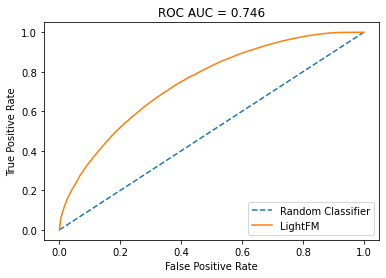

In [11]:
show_roc_curve(test_data.rating, preds)

# EDA

In [13]:
# Reading json file and puting separate parts into meta_list
with open (folder + 'meta_Grocery_and_Gourmet_Food.json') as f:
    meta_list = []
    for line in f.readlines():
        try:
            meta_list.append(Grocery.parse_raw(line))
        except ValidationError as e:
            pass
meta = pd.DataFrame.from_records([[s.category, s.description, s.price,s.title, s.also_view, s.date, s.rank, s.also_buy, s.main_cat,s.image,s.asin] for s in meta_list])
meta.columns = ['category','description','price','title','also_view','date','rank','also_buy','main_cat','image','asin']
meta.to_csv('meta.csv')        
gc.collect()

0

In [14]:
meta.sample(5)

,category,description,price,title,also_view,date,rank,also_buy,main_cat,image,asin
204508,"[Grocery & Gourmet Food, Beverages, Coffee, Te...",[Delight and arouse your senses with hand-craf...,None,"Artisan Coffee, Hazelnut, 12 Ounce",None,None,1.071,None,Grocery,[https://images-na.ssl-images-amazon.com/image...,B00LN2TFTG
140431,"[Grocery & Gourmet Food, Breads & Bakery, Pack...","[Artisan Bread, These rustic loaves have a his...",None,"Bread Alone, Organic Nine Mixed Grain, Pullman...",None,None,228.032,"[B0004MZVEE, B00061CAPG, B004JX7OPI]",Grocery,[https://images-na.ssl-images-amazon.com/image...,B00C4RVJQQ
94727,"[Grocery & Gourmet Food, Beverages, Coffee, Te...",None,None,The Republic Of Tea Plantain Coconut Green Roo...,"[B004HBNHTY, B001B2SY9U, B0024SIHAG]",None,314.668,None,Grocery,[https://images-na.ssl-images-amazon.com/image...,B005SHMSSW
187861,"[Grocery & Gourmet Food, Candy & Chocolate, Ca...","[The full name, King Choc Nut Peanut Milk Choc...",$40.46,King Choc*Nut Peanut Milk Chocolate 24pcs. (La...,"[B079WQHH42, B07F51ZCJ2, B001L4826I, B00VMSBCO...",None,589.565,None,Grocery,None,B00IYO85AQ
177430,"[Grocery & Gourmet Food, Snack Foods, Chips & ...",None,None,UTZ Onion and Garlic Potato Chips 3.5 Ounces (...,[B0070DVAXQ],None,390.016,[B0070DVAXQ],Grocery,None,B00HIPVHMK


In [15]:
train.sample(5)

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
445555,5.0,True,"08 2, 2017",B0055IRNAC,Trudy A Petersen,This is now a staple at my house as I use it f...,Five Stars,1501632000,NaN,{'Size:': ' 4 Pound'},NaN,30795,15222,1.0
593540,4.0,False,"09 6, 2015",B00I471G9K,ChibiNeko,Whether or not you'll enjoy this will depend h...,"Good, but pricey",1441497600,4,{'Style:': ' Double Dark Chocolate - Pack of 12'},NaN,15998,27299,1.0
832250,5.0,True,"03 4, 2016",B017WOLVQ8,Roger L. Williams,good coffee no complaints,good joe,1457049600,NaN,"{'Size:': ' Variety 72 Count', 'Flavor:': ' Da...",NaN,45493,36016,1.0
646815,5.0,True,"09 29, 2014",B001LNZEYM,mdnyc,Its great to have a company who hasn't sold ou...,Tastes great!,1411948800,5,NaN,NaN,60939,8998,1.0
641677,5.0,True,"11 6, 2017",B000HZGZES,gfdfg,Good beef flavor and easy to use.,Five Stars,1509926400,NaN,{'Size:': ' 8 Count'},NaN,6883,2706,1.0


In [16]:
test.sample(5)

,verified,reviewTime,asin,reviewerName,unixReviewTime,vote,style,image,userid,itemid,Id
19122,True,"10 26, 2017",B00R7PWK7W,Trekboi,1508976000,NaN,NaN,NaN,56322,32046,19122
223200,True,"09 15, 2017",B0018GD1NI,Colorado Avid Reader,1505433600,NaN,NaN,NaN,91650,6720,223200
261199,True,"04 10, 2015",B0029JFZZU,JC in Texas,1428624000,NaN,NaN,NaN,125300,10381,261199
105782,True,"04 15, 2018",B002FW4WFK,Rebecca Hudson,1523750400,NaN,{'Flavor:': ' BLUE CHEESE DIP'},NaN,98709,10767,105782
250366,True,"11 2, 2015",B00E1EK81W,utahsand,1446422400,NaN,{'Size:': ' 9-ounce'},NaN,570,24351,250366


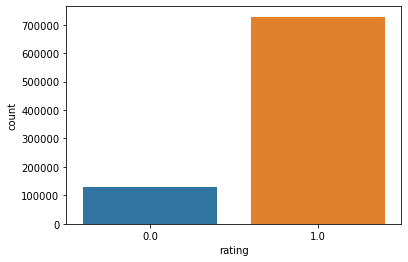

In [17]:
ax = sns.countplot(x='rating', data=train)

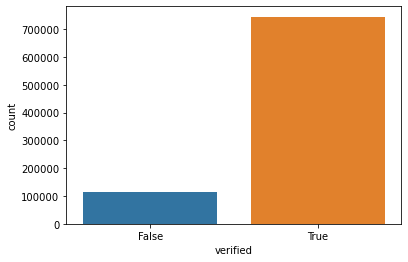

In [18]:
ax = sns.countplot(x='verified', data=train)

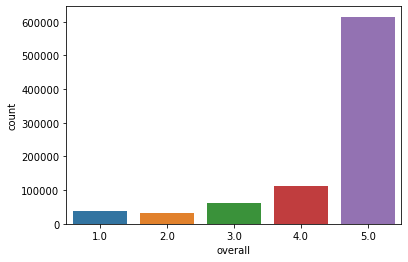

In [19]:
ax = sns.countplot(x='overall', data=train)

Will use StratifiedKFold, as features are unbalanced. Or try over/undersampling

In [20]:
unique_obj = set(test.asin) - set.intersection(set(train.asin),set(test.asin))
print("Objects missing from train", unique_obj)
for met in unique_obj:
    display(meta[ meta.asin == met])

Objects missing from train {'B00L3SU3IC', 'B000YAH13A', 'B0017I1QAW', 'B000H25VSM', 'B0015AT3BG', 'B00XMZB1LC', 'B0155W3W7A', 'B00CP79A84', 'B00176QPJG', 'B000WW6VZO', 'B00ZNK5KQ6', 'B001682QMA', 'B000X0Z9CQ', 'B0016CZ5L0', 'B014LT33M2', 'B000GW2406', 'B000YINEYW', 'B00U69Q0ZE'}


,category,description,price,title,also_view,date,rank,also_buy,main_cat,image,asin
202117,"[Grocery & Gourmet Food, Beverages, Bottled Be...",[Easy for on the go use. All naturally sweeten...,$33.95,Skinnygirl Liquid Water Enhancer White Cherry ...,None,None,65.518,"[B00J80X54G, B00K9EYJ36, B00K330E46, B00J815O1...",Grocery,[https://images-na.ssl-images-amazon.com/image...,B00L3SU3IC


,category,description,price,title,also_view,date,rank,also_buy,main_cat,image,asin
29071,"[Grocery & Gourmet Food, Food & Beverage Gifts...",[Send your heartfelt sympathy to friends and l...,$49.99,Art of Appreciation Gift Baskets With Heartfel...,"[B00F4WIQ96, B00ZRWPZPQ, B00QPHNUYU, B0097GS4I...",None,229.506,None,Grocery,[https://images-na.ssl-images-amazon.com/image...,B000YAH13A


,category,description,price,title,also_view,date,rank,also_buy,main_cat,image,asin
34324,"[Grocery & Gourmet Food, Snack Foods, Salsas, ...","[Arriba! Salsas deliver a rich, fresh, grilled...",$26.49,"Arriba! Fire Roasted Mexican Red Salsa, Hot, 1...","[B001HTKV1G, B00CIVY3FW, B00A9OEUJY, B00HMUUU60]",None,444.147,None,Grocery,None,B0017I1QAW


,category,description,price,title,also_view,date,rank,also_buy,main_cat,image,asin
15162,"[Grocery & Gourmet Food, Sauces, Gravies & Mar...",[Chipotle peppers are a smoked red jalapeno pe...,$27.01,"Embasa Chipotle Peppers in Adobo Sauce, 7-Ounc...","[B000QJSACU, B00061DFEQ, B00G0JSW0U, B0014CVT6...",None,177.661,None,Grocery,[https://images-na.ssl-images-amazon.com/image...,B000H25VSM


,category,description,price,title,also_view,date,rank,also_buy,main_cat,image,asin
32960,"[Grocery & Gourmet Food, Candy & Chocolate, Ca...","[Chewy, vanilla flavored nougat wrapped in a r...",$25.59,Charleston Chew Bar Vanilla 24 Pac,"[B00A8HSA52, B003EYNJMA, B003VTLOQQ, B07J5W562...",None,30.981,"[B0015AUZ04, B003VTLOQQ, B003WEDT4A, B00A8HSA5...",Grocery,None,B0015AT3BG


,category,description,price,title,also_view,date,rank,also_buy,main_cat,image,asin
244679,"[Grocery & Gourmet Food, Condiments & Salad Dr...",[Mustards from the Dijon region of France are ...,$14.99,"Maille Old Style Grain Dijon Mustard, 7.3 oz",None,None,53.058,"[B0053OD50A, B0027HUUNG, B0001BH5YM, B078P773N...",Grocery,[https://images-na.ssl-images-amazon.com/image...,B00XMZB1LC


,category,description,price,title,also_view,date,rank,also_buy,main_cat,image,asin
257471,"[Grocery & Gourmet Food, Cooking & Baking, Coo...",None,$19.95,Extra Virgin First Cold Pressed Olive Oil 500m...,None,None,170.642,"[B01EPAH03U, B01NB1ZNS5, B005WF768C, B00CX6WT9...",Grocery,[https://images-na.ssl-images-amazon.com/image...,B0155W3W7A


,category,description,price,title,also_view,date,rank,also_buy,main_cat,image,asin
146744,"[Grocery & Gourmet Food, Beverages, Bottled Be...",None,$29.44,"Glaceau Smart Water, 500ml (Pack of 12)",None,None,69.774,"[B073WWZ22T, B01MSY8JI9, B06XZYX65P, B00KIG3WP...",Grocery,None,B00CP79A84


,category,description,price,title,also_view,date,rank,also_buy,main_cat,image,asin
34246,"[Grocery & Gourmet Food, Beverages, Coffee, Te...",[This is a multi-layered blend of medium- and ...,$22.50,Caffe Vita Queen City Whole Bean (Medium-Dark)...,"[B002GJY2CU, B00176MUH2, B00176QPH8, B01N4JBH3...",None,41.297,"[B002GJY2CU, B00176MUH2, B00176QPH8, B00176QPI...",Grocery,[https://images-na.ssl-images-amazon.com/image...,B00176QPJG


,category,description,price,title,also_view,date,rank,also_buy,main_cat,image,asin
28642,"[Grocery & Gourmet Food, Snack Foods, Cookies,...",[This is a fun new way to get a party started ...,$275.00,"Greenfire Custom Fortune Cookies, for Special ...","[B074Q3CH6C, B000I07O10, B000CBEP9O, B00750E0X...",None,478.636,None,Grocery,[https://images-na.ssl-images-amazon.com/image...,B000WW6VZO


,category,description,price,title,also_view,date,rank,also_buy,main_cat,image,asin
248305,"[Grocery & Gourmet Food, Beverages, Coffee, Te...",[Our first offering from the exclusive Oaks te...,None,2017 Harvest Premium Darjeeling Loose Leaf Bla...,"[B014GLC2LS, B014WCN60M, B00VFYPG1S, B00S0NYCCG]",None,330.516,None,Grocery,[https://images-na.ssl-images-amazon.com/image...,B00ZNK5KQ6


,category,description,price,title,also_view,date,rank,also_buy,main_cat,image,asin
33601,"[Grocery & Gourmet Food, Breads & Bakery, Pizz...",[Appian Way Pizza complete with crust mix and ...,$56.99,Appian Way Pizza Crust Mix (Pack of 12),"[B0025UCFYC, B00IDPSOR0, B00IDPOPSW, B00IDPX1V...",None,187.815,None,Grocery,None,B001682QMA


,category,description,price,title,also_view,date,rank,also_buy,main_cat,image,asin
28682,"[Grocery & Gourmet Food, Breads & Bakery, Cakes]",[Hsin Tung Yang Green Bean Cake with Red Bean ...,$10.00,Traditional Taiwanese All Natural Vegetarian S...,"[B06Y6TYWFK, B001M04TC2, B00E5OB0JM, B07FYX19G...",None,258.584,"[B001M04TC2, B00E5OB0JM, B0051D83SW, B01LZSA84...",Grocery,[https://images-na.ssl-images-amazon.com/image...,B000X0Z9CQ


,category,description,price,title,also_view,date,rank,also_buy,main_cat,image,asin
33896,"[Grocery & Gourmet Food, Beverages, Coffee, Te...",[Novus Citrus Chamomile Herbal Tea is made sin...,None,"Novus Citrus Chamomile Herbal Tea, Caffeine Fr...",None,None,917.358,None,Grocery,None,B0016CZ5L0


,category,description,price,title,also_view,date,rank,also_buy,main_cat,image,asin
256270,"[Grocery & Gourmet Food, Dairy, Cheese & Eggs,...","[, Buttered Popcorn is pretty much the best th...",$19.99,Real Popcorn Butter Topping Tru-POP 12oz NEW ITEM,"[B00K2B4AY4, B01CDBBB92, B002YLNUL4, B0785827P...",None,102.077,"[B0051WBPHY, B004W8LT10, B01CDBBB92, B01BO3E7E...",Grocery,[https://images-na.ssl-images-amazon.com/image...,B014LT33M2


,category,description,price,title,also_view,date,rank,also_buy,main_cat,image,asin
14753,"[Grocery & Gourmet Food, Snack Foods, Jerky & ...","[Super size., Beef, Salt, Corn Syrup, Spices, ...",None,"Jack Link's Super Size Beef Sticks, Original, ...",None,None,None,None,Grocery,None,B000GW2406


,category,description,price,title,also_view,date,rank,also_buy,main_cat,image,asin
29330,"[Grocery & Gourmet Food, Beverages, Bottled Be...","[Apple Tea, Safety button pops up when origina...",None,Snapple FruitJuice Apple 16 oz Glass Bottle (6...,"[B004OE2Z3I, B06VSG521B, B07B1L2KNS, B07GRBQ76...",None,160.137,None,Grocery,[https://images-na.ssl-images-amazon.com/image...,B000YINEYW


,category,description,price,title,also_view,date,rank,also_buy,main_cat,image,asin
236034,"[Grocery & Gourmet Food, Beverages, Coffee, Te...","[A seductive mix of full-bodied Arabica beans,...",$12.30,"Double Donut Italian Roast Coffee, in Recyclab...",None,None,170.729,"[B00U69Q6JE, B00U69Q03G, B013HNTQII, B013HNTXM...",Grocery,[https://images-na.ssl-images-amazon.com/image...,B00U69Q0ZE


### Data preprocessing

In [21]:
meta.isna().sum()

category            0
description     35407
price          155073
title               4
also_view      166197
date           277546
rank            11715
also_buy       203877
main_cat         1493
image          136995
asin                0
dtype: int64

In [22]:
train.isna().sum()

overall                0
verified               0
reviewTime             0
asin                   0
reviewerName         176
reviewText           279
summary              170
unixReviewTime         0
vote              739155
style             413489
image             850753
userid                 0
itemid                 0
rating                 0
dtype: int64

In [23]:
test.isna().sum()

verified               0
reviewTime             0
asin                   0
reviewerName          47
unixReviewTime         0
vote              246503
style             138285
image             283597
userid                 0
itemid                 0
Id                     0
dtype: int64

Features to drop:
 - style - products' package size, taste, too many missing values that can not be filled
 - reviewerName - not informative
 - reviewTime - replaced with unixReviewTime
 - link to image, too many missing values, not informative

In [24]:
train = train.drop([ 'reviewTime', 'reviewerName', 'style'], axis=1)

In [25]:
test = test.drop([ 'reviewTime', 'reviewerName', 'style'], axis=1)

Let's add information from meta to train and test

In [26]:
# replace incorrect titles with 'missing'
meta.loc[meta.title.str.contains('var aPageStart') == True, 'title'] = 'missing'

In [27]:
category_dict = dict(zip(meta['asin'],meta['category']))
title_dict = dict(zip(meta['asin'],meta['title']))
rank_dict = dict(zip(meta['asin'],meta['rank']))
image_dict = dict(zip(meta['asin'],meta['image']))
buy_dict = dict(zip(meta['asin'],meta['also_buy']))

In [28]:
train['category'] = train.asin.apply(lambda x: category_dict[x])
test['category'] = test.asin.apply(lambda x: category_dict[x])

train['title'] = train.asin.apply(lambda x: title_dict[x])
test['title'] = test.asin.apply(lambda x: title_dict[x])

train['image'] = train[pd.isna(train.image)].asin.apply(lambda x: image_dict[x])
test['image'] = test[pd.isna(test.image)].asin.apply(lambda x: image_dict[x])

train['rank'] = train.asin.apply(lambda x: rank_dict[x])
test['rank'] = test.asin.apply(lambda x: rank_dict[x])

train['also_buy'] = train.asin.apply(lambda x: buy_dict[x])
test['also_buy'] = test.asin.apply(lambda x: buy_dict[x])

gc.collect()

4833

**Most popular categories**

In [29]:
train.category.explode().value_counts().sort_values(ascending=False)

Grocery & Gourmet Food    857895
Beverages                 226050
Coffee, Tea & Cocoa       173805
Cooking & Baking          167544
Snack Foods               106450
                           ...  
Marshmallow                    3
Tulips                         3
Havarti                        3
Sofrito Sauce                  3
Tomatillos                     2
Name: category, Length: 1003, dtype: int64

In [30]:
test.category.explode().value_counts().sort_values(ascending=False)

Grocery & Gourmet Food    285965
Beverages                  75369
Coffee, Tea & Cocoa        57994
Cooking & Baking           55814
Snack Foods                35640
                           ...  
Safflower                      1
Light Cream                    1
Thai Chili                     1
Bologna                        1
Ribs                           1
Name: category, Length: 993, dtype: int64

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857895 entries, 0 to 857894
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         857895 non-null  float64
 1   verified        857895 non-null  bool   
 2   asin            857895 non-null  object 
 3   reviewText      857616 non-null  object 
 4   summary         857725 non-null  object 
 5   unixReviewTime  857895 non-null  int64  
 6   vote            118740 non-null  object 
 7   image           759417 non-null  object 
 8   userid          857895 non-null  int64  
 9   itemid          857895 non-null  int64  
 10  rating          857895 non-null  float64
 11  category        857895 non-null  object 
 12  title           857895 non-null  object 
 13  rank            820744 non-null  object 
 14  also_buy        735468 non-null  object 
dtypes: bool(1), float64(2), int64(3), object(9)
memory usage: 92.5+ MB


In [32]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285965 entries, 0 to 285964
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   verified        285965 non-null  bool  
 1   asin            285965 non-null  object
 2   unixReviewTime  285965 non-null  int64 
 3   vote            39462 non-null   object
 4   image           252969 non-null  object
 5   userid          285965 non-null  int64 
 6   itemid          285965 non-null  int64 
 7   Id              285965 non-null  int64 
 8   category        285965 non-null  object
 9   title           285965 non-null  object
 10  rank            273606 non-null  object
 11  also_buy        245362 non-null  object
dtypes: bool(1), int64(4), object(7)
memory usage: 24.3+ MB


### Fixing columns, filling missing values

**verified**

In [33]:
verified_dict = {
    True: 1,
    False: 0
}

In [34]:
train.verified = train.verified.map(verified_dict)
test.verified = test.verified.map(verified_dict)

**reviewText**

In [35]:
# droping due to the fact that there's no such column in test
train = train.drop(['reviewText'], axis=1)

In [36]:
# same for summary
train = train.drop(['summary'], axis=1)

**unixReviewTime**

Transform this feature into categorial one:
- before 2015 - old
- 2015-2017 - mid
- 2018+ - new

<AxesSubplot:>

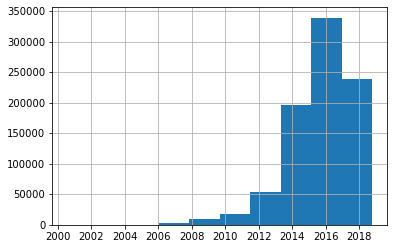

In [37]:
pd.to_datetime(train.unixReviewTime.apply(lambda x: datetime.utcfromtimestamp(x))).hist()

<AxesSubplot:>

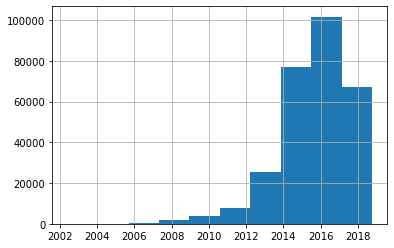

In [38]:
pd.to_datetime(test.unixReviewTime.apply(lambda x: datetime.utcfromtimestamp(x))).hist()

In [39]:
train['year'] = pd.to_datetime(train.unixReviewTime.apply(lambda x: datetime.utcfromtimestamp(x))).dt.year
test['year'] = pd.to_datetime(test.unixReviewTime.apply(lambda x: datetime.utcfromtimestamp(x))).dt.year

In [40]:
def review_cat(row):
    if row < 2015:
        return 'old'
    elif (row >= 2015) & (row <= 2017):
        return 'mid'
    return 'new'

In [41]:
train['reviewTime_cat'] = train.year.apply(review_cat)
train.reviewTime_cat.value_counts(dropna=False)

mid    527822
old    256326
new     73747
Name: reviewTime_cat, dtype: int64

In [42]:
test['reviewTime_cat'] = test.year.apply(review_cat)
test.reviewTime_cat.value_counts(dropna=False)

mid    175783
old     85676
new     24506
Name: reviewTime_cat, dtype: int64

In [43]:
train = train.drop(['year', 'unixReviewTime'], axis=1)
test = test.drop(['year', 'unixReviewTime'], axis=1)

**image**

transform this feature into binary one: "has an image", 'no image'

In [44]:
train.image = train.image.fillna(0)
test.image = test.image.fillna(0)

In [45]:
train.loc[train.image != 0, 'image'] = 1
test.loc[test.image != 0, 'image'] = 1

In [46]:
test.image.value_counts(dropna=False)

1    252969
0     32996
Name: image, dtype: int64

In [47]:
train.category

0         [Grocery & Gourmet Food, Herbs, Spices & Seaso...
1         [Grocery & Gourmet Food, Beverages, Coffee, Te...
2         [Grocery & Gourmet Food, Beverages, Bottled Be...
3         [Grocery & Gourmet Food, Herbs, Spices & Seaso...
4         [Grocery & Gourmet Food, Snack Foods, Chips & ...
                                ...                        
857890      [Grocery & Gourmet Food, Produce, Fresh Fruits]
857891    [Grocery & Gourmet Food, Beverages, Coffee, Te...
857892    [Grocery & Gourmet Food, Pasta & Noodles, Nood...
857893    [Grocery & Gourmet Food, Snack Foods, Bars, Nu...
857894    [Grocery & Gourmet Food, Cooking & Baking, Syr...
Name: category, Length: 857895, dtype: object

**rank**

fill missing values with 0 and normalize rank values

In [48]:
train['rank'] = train['rank'].astype(float)
test['rank'] = test['rank'].astype(float)
train['rank'].fillna(value=0, inplace=True)
test['rank'].fillna(value=0, inplace=True)

train['rank']= (train['rank'] - train['rank'].mean())/ train['rank'].std()
test['rank']= (test['rank'] - test['rank'].mean())/ test['rank'].std()

**vote**

In [49]:
train.vote = train.vote.fillna(0)
test.vote = test.vote.fillna(0)

In [50]:
def replace_vote(df):
    df['vote'] = df['vote'].astype('str')
    df['vote'] = df['vote'].apply(lambda x: x.replace(',', ''))
    df['vote'] = df['vote'].astype('float')
    df['vote'] = df['vote'].astype('int32')
    return df

In [51]:
train = replace_vote(train)
test = replace_vote(test)

In [52]:
#normalize
train['vote']= (train['vote'] - train['vote'].mean())/ train['vote'].std()
test['vote']= (test['vote'] - test['vote'].mean())/ test['vote'].std()

**also_buy**

Something definitely can be done and used here, but I am not sure what exactly can be done

In [53]:
also_buy = train.also_buy.explode().value_counts().sort_values(ascending=False)

In [54]:
train = train.drop(['also_buy'], axis=1)
test = test.drop(['also_buy'], axis=1)

Let's create dummies for categorial columns

In [55]:
test = test.drop(['Id'], axis=1)

In [56]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857895 entries, 0 to 857894
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         857895 non-null  float64
 1   verified        857895 non-null  int64  
 2   asin            857895 non-null  object 
 3   vote            857895 non-null  float64
 4   image           857895 non-null  object 
 5   userid          857895 non-null  int64  
 6   itemid          857895 non-null  int64  
 7   rating          857895 non-null  float64
 8   category        857895 non-null  object 
 9   title           857895 non-null  object 
 10  rank            857895 non-null  float64
 11  reviewTime_cat  857895 non-null  object 
dtypes: float64(4), int64(3), object(5)
memory usage: 78.5+ MB


In [57]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285965 entries, 0 to 285964
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   verified        285965 non-null  int64  
 1   asin            285965 non-null  object 
 2   vote            285965 non-null  float64
 3   image           285965 non-null  object 
 4   userid          285965 non-null  int64  
 5   itemid          285965 non-null  int64  
 6   category        285965 non-null  object 
 7   title           285965 non-null  object 
 8   rank            285965 non-null  float64
 9   reviewTime_cat  285965 non-null  object 
dtypes: float64(2), int64(3), object(5)
memory usage: 21.8+ MB


In [58]:
train

,overall,verified,asin,vote,image,userid,itemid,rating,category,title,rank,reviewTime_cat
0,5.0,1,B01CPNIEQG,-0.116893,1,102179,37138,1.0,"[Grocery & Gourmet Food, Herbs, Spices & Seaso...","Primal Palate Organic Spices Adobo Seasoning, ...",-0.595238,mid
1,5.0,1,B006F63M8U,-0.116893,1,3625,17322,1.0,"[Grocery & Gourmet Food, Beverages, Coffee, Te...",Milk Chocolate Swiss Miss Hot Cocoa Mix 60-0.7...,-0.681183,mid
2,5.0,1,B00112O8NG,3.397513,1,39495,5600,1.0,"[Grocery & Gourmet Food, Beverages, Bottled Be...","Torani Syrup, Sugar Free Vanilla, 25.4 oz",-0.715070,mid
3,5.0,1,B00MRAQUM8,-0.116893,1,72854,30249,1.0,"[Grocery & Gourmet Food, Herbs, Spices & Seaso...",Frontier Herb Organic Powdered Ceylon Cinnamon...,0.308737,old
4,5.0,1,B000R7RN0G,-0.116893,1,74859,4349,1.0,"[Grocery & Gourmet Food, Snack Foods, Chips & ...",Miss Vickie's Jalapeño Flavored Kettle Cooked ...,-0.341167,mid
...,...,...,...,...,...,...,...,...,...,...,...,...
857890,5.0,1,B000H7ELTW,-0.116893,1,59433,2566,1.0,"[Grocery & Gourmet Food, Produce, Fresh Fruits]","Traverse Bay Fruit Dried Cranberries, 4 Pound",-0.555617,old
857891,2.0,1,B0012NI02O,-0.116893,1,86473,5828,0.0,"[Grocery & Gourmet Food, Beverages, Coffee, Te...","Ahmad Tea Darjeeling Tea, 3.5-Ounce Tins (Pack...",3.645980,mid
857892,4.0,0,B000LKX6R8,-0.116893,1,88,3251,1.0,"[Grocery & Gourmet Food, Pasta & Noodles, Nood...","Hakubaku Organic Soba, Authentic Japanese Buck...",-0.626495,mid
857893,4.0,1,B00BUKL666,-0.116893,1,41540,22208,1.0,"[Grocery & Gourmet Food, Snack Foods, Bars, Nu...","KIND Bars, Dark Chocolate Nuts & Sea Salt, Glu...",-0.605972,mid


**Dummy**

In [59]:
cat_cols = ['category', 'reviewTime_cat']

In [60]:
# selecting top 10 categories
train_category = train.explode('category')
cat_freq = train_category.category.value_counts()
top_cat_count = int(np.percentile(cat_freq, 90))
top_cat_count = len(train_category.category.value_counts()[:10])

# replacing remaining categories with other
all_cats = train_category.category.value_counts().index
top_cats = list(all_cats)[:top_cat_count]
cats_to_throw_away = list(set(all_cats) - set(top_cats))
train_category.loc[train_category['category'].isin(cats_to_throw_away), 'category'] = 'other_cat'

# create dummy
cat_dummies = pd.get_dummies(train_category['category'])
# concat
train_category = pd.concat([train_category, cat_dummies], axis=1)

# reverse explode
train = train_category.groupby(train_category.index).max().copy()


In [61]:
train.drop(['category'], axis=1, inplace=True)

In [62]:
# selecting top 10 categories
test_category = test.explode('category')
cat_freq = test_category.category.value_counts()
top_cat_count = int(np.percentile(cat_freq, 90))
top_cat_count = len(test_category.category.value_counts()[:10])

# replacing remaining categories with other
all_cats = test_category.category.value_counts().index
top_cats = list(all_cats)[:top_cat_count]
cats_to_throw_away = list(set(all_cats) - set(top_cats))
test_category.loc[test_category['category'].isin(cats_to_throw_away), 'category'] = 'other_cat'

# create dummy
cat_dummies = pd.get_dummies(test_category['category'])
# concat
test_category = pd.concat([test_category, cat_dummies], axis=1)

# reverse explode
test = test_category.groupby(test_category.index).max().copy()

In [63]:
test.drop(['category'], axis=1, inplace=True)

In [64]:
dummies = pd.get_dummies(train['reviewTime_cat'], prefix = train['reviewTime_cat'].name)
train = pd.concat([train, dummies], axis=1)

In [65]:
train.drop(['reviewTime_cat'], axis=1, inplace=True)

In [66]:
dummies_test = pd.get_dummies(test['reviewTime_cat'], prefix = test['reviewTime_cat'].name)
test = pd.concat([test, dummies_test], axis=1)
test.drop(['reviewTime_cat'], axis=1, inplace=True)

In [67]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285965 entries, 0 to 285964
Data columns (total 22 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   verified                      285965 non-null  int64  
 1   asin                          285965 non-null  object 
 2   vote                          285965 non-null  float64
 3   image                         285965 non-null  int64  
 4   userid                        285965 non-null  int64  
 5   itemid                        285965 non-null  int64  
 6   title                         285965 non-null  object 
 7   rank                          285965 non-null  float64
 8   Beverages                     285965 non-null  uint8  
 9   Candy & Chocolate             285965 non-null  uint8  
 10  Coffee                        285965 non-null  uint8  
 11  Coffee, Tea & Cocoa           285965 non-null  uint8  
 12  Cooking & Baking              285965 non-nul

# Machine Learning

## model1 - LightFM

In [68]:
y = train.rating
X = train.drop(columns=['rating'],inplace=False)

C:\Users\serge\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


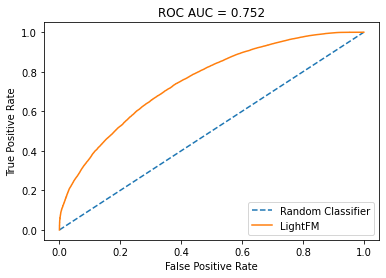

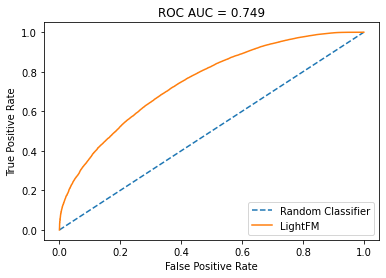

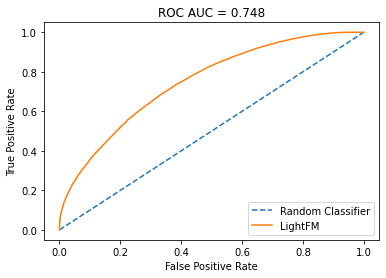

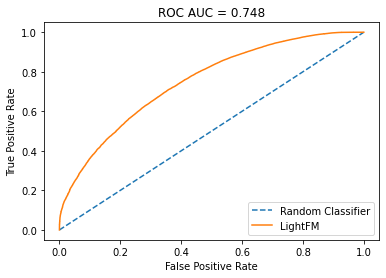

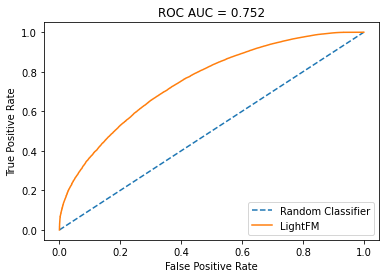

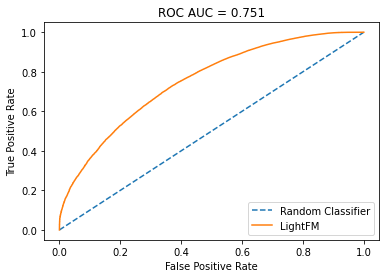

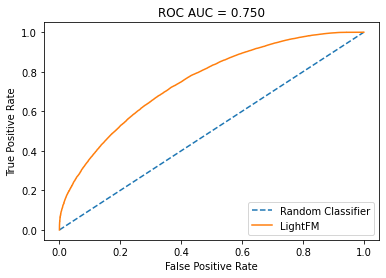

In [69]:
from sklearn.model_selection import StratifiedKFold

NUM_THREADS = 4 #число потоков
NUM_COMPONENTS = 30 #число параметров вектора 
NUM_EPOCHS = 20 #число эпох обучения

skf = StratifiedKFold(n_splits=7,random_state=RANDOM_SEED)

for train_idx, valid_idx in skf.split(X, y):
    ratings_coo = sparse.coo_matrix((y[train_idx].astype(int),
                                 (X['userid'][train_idx],
                                  X['itemid'][train_idx])))
    
    model = LightFM(learning_rate=0.05,
                    loss='logistic',
                    no_components=NUM_COMPONENTS,
                    random_state=RANDOM_SEED)

    #Обучаем модель
    model = model.fit(ratings_coo, epochs=NUM_EPOCHS, num_threads=NUM_THREADS)
    preds = model.predict(X['userid'][valid_idx].values, X['itemid'][valid_idx].values)
    show_roc_curve(y[valid_idx], preds)

In [71]:
def fill_report(df, model_name, score, sub_score):
    
    temp_df = pd.DataFrame({
        'model': model_name,
        'local_score': score,
        'submit_score': sub_score
    }, index=[len(report_df)])
    
    temp_df = report_df.append(temp_df)
    return temp_df

In [72]:
report_df = pd.DataFrame(columns=['model', 'local_score', 'submit_score'])

In [73]:
report_df = fill_report(report_df, 'LightFM_StratKFold', 0.752, 0.74887)

**Oversampling**

In [74]:
oversample = RandomOverSampler(sampling_strategy=1)
X_over, y_over = oversample.fit_resample(X, y)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over,random_state=RANDOM_SEED, shuffle=True)

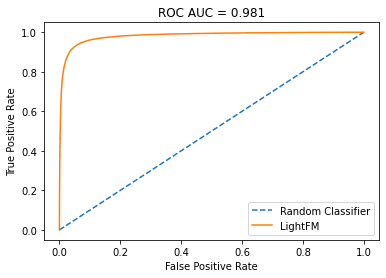

In [76]:
ratings_coo_over = sparse.coo_matrix((y_train.astype(int),
                             (X_train['userid'],
                              X_train['itemid'])))

model_over = LightFM(learning_rate=0.05,
                loss='logistic',
                no_components=NUM_COMPONENTS,
                random_state=RANDOM_SEED)


model_over = model_over.fit(ratings_coo_over, epochs=NUM_EPOCHS, num_threads=NUM_THREADS)
preds_over = model_over.predict(X_test['userid'].values, X_test['itemid'].values)
show_roc_curve(y_test, preds_over)

In [96]:
preds_sub = model_over.predict(test.userid.values,
                      test.itemid.values)
normalized_preds = (preds_sub - preds_sub.min())/(preds_sub - preds_sub.min()).max()

submission['rating']= normalized_preds

submission.to_csv('submission_log_oversample.csv', index=False)

Seems to be overfitted, however, it shows better score on submit. Let's try to implement StratifiedKFold

In [97]:
report_df = fill_report(report_df, 'LightFM_Oversampled', 0.981, 0.75658)

C:\Users\serge\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


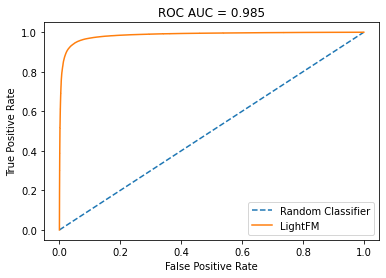

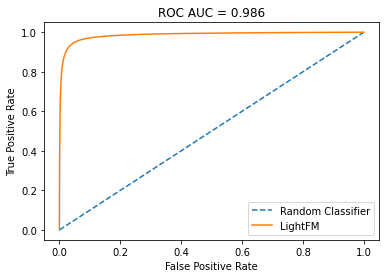

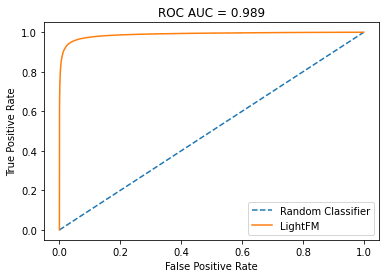

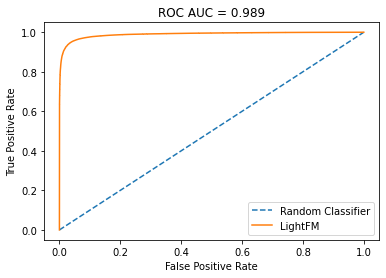

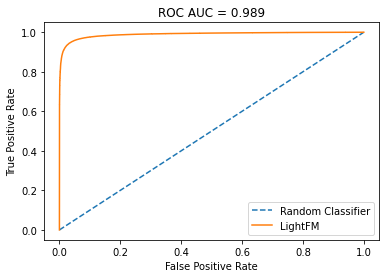

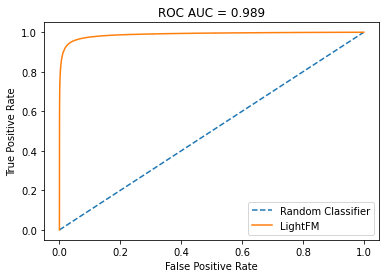

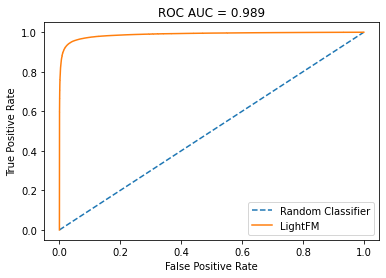

In [99]:
skf = StratifiedKFold(n_splits=7,random_state=RANDOM_SEED)

for train_idx, valid_idx in skf.split(X_over, y_over):
    ratings_coo = sparse.coo_matrix((y_over[train_idx].astype(int),
                                 (X_over['userid'][train_idx],
                                  X_over['itemid'][train_idx])))
    
    model_over_strat = LightFM(learning_rate=0.05,
                    loss='logistic',
                    no_components=NUM_COMPONENTS,
                    random_state=RANDOM_SEED)

    #Обучаем модель
    model_over_strat = model_over_strat.fit(ratings_coo, epochs=NUM_EPOCHS, num_threads=NUM_THREADS)
    preds = model_over_strat.predict(X_over['userid'][valid_idx].values, X_over['itemid'][valid_idx].values)
    show_roc_curve(y_over[valid_idx], preds)

In [100]:
preds_sub = model_over_strat.predict(test.userid.values,
                      test.itemid.values)
normalized_preds = (preds_sub - preds_sub.min())/(preds_sub - preds_sub.min()).max()

submission['rating']= normalized_preds

submission.to_csv('submission_log_oversample_strat.csv', index=False)

In [101]:
report_df = fill_report(report_df, 'LightFM_Oversampled_StratKFold', 0.989, 0.75799)

Seems to be best option, even though model is overfitted in local testing

**Undersampling**

In [77]:
undersample = RandomUnderSampler(sampling_strategy=1)
X_under, y_under = undersample.fit_resample(X, y)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under,random_state=RANDOM_SEED, shuffle=True)

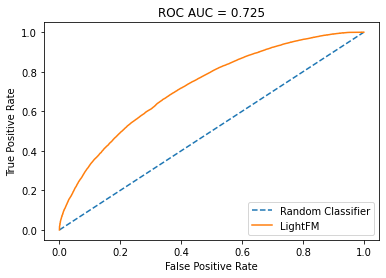

In [79]:
ratings_coo_under = sparse.coo_matrix((y_train.astype(int),
                             (X_train['userid'],
                              X_train['itemid'])))

model_under = LightFM(learning_rate=0.05,
                loss='logistic',
                no_components=NUM_COMPONENTS,
                random_state=RANDOM_SEED)


model_under = model_under.fit(ratings_coo_under, epochs=NUM_EPOCHS, num_threads=NUM_THREADS)
preds_under = model_under.predict(X_test['userid'].values, X_test['itemid'].values)
show_roc_curve(y_test, preds_under)

# Submission

In [103]:
preds_sub = model_over_strat.predict(test.userid.values,
                      test.itemid.values)


In [104]:
preds_sub.min(), preds.max()

(-36.36509, 32.198757)

In [105]:
normalized_preds = (preds_sub - preds_sub.min())/(preds_sub - preds_sub.min()).max()

In [106]:
normalized_preds.min(), normalized_preds.max()


(0.0, 1.0)

In [107]:
submission['rating']= normalized_preds

In [108]:
submission.to_csv('submission_final.csv', index=False)